<a href="https://colab.research.google.com/github/puneethkumarvydya/Capstone-Project/blob/Ganesh's-Branch/Capstone_Project_AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Pneumonia detection from chest X-Ray images 

# Project Description


In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related. In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data. Details about the data and dataset files are given in below link, https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

# Pre-Processing, Data Visualization, EDA
 Exploring the given Data files, classes and images of different classes.

 Dealing with missing values

 Visualization of different classes

 Analysis from the visualization of different classes.

# Model Building
 Building a pneumonia detection model starting from basic CNN and then improving upon it.
 Train the model

 To deal with large training time, save the weights so that you can use them when training the

model for the second time without starting from scratch.

 **Test the model and report as per evaluation metrics**

 Try different models

 Set different hyper parameters, by trying different optimizers, loss functions, epochs, learning

rate, batch size, checkpointing, early stopping etc. for these models to fine-tune them

 Report evaluation metrics for these models along with your observation on how changing

different hyper parameters leads to change in the final evaluation metric.

In [4]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Let’s start with loading all the libraries and dependencies.

In [6]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
#tf.set_random_seed(seed)

In [7]:
os.chdir('/content/drive/My Drive/projects/capstone_project/Capestone/')
#path = ('.')
os.listdir()

['Pneumonia Detection Challenge Brief.pdf',
 'Interim Report Format.pdf',
 'Final Report Format.pdf',
 'rsna-pneumonia-detection-challenge.zip',
 'Capstone_Project_AIML.ipynb',
 'stage_2_test_images',
 'stage_2_train_images',
 'stage_2_train_labels.csv',
 'GCP Credits Request Link - RSNA.txt',
 'stage_2_sample_submission.csv',
 'stage_2_detailed_class_info.csv']

# All our images are in the zip file so we need to extract the contents of this file

In [ ]:
#images_zip_path = project_path + 'Aligned Face Dataset from Pinterest.zip' #"images.zip"
#from zipfile import ZipFile
#with ZipFile("rsna-pneumonia-detection-challenge.zip",'r') as z:
#  z.extractall()

## DICOM images are generally used to store medical images. They are highly informative. Along with image data it stores lots of key patient information, such as, patient’s name, age, sex, doctor’s name etc.

## ##If you just want to preview dicom images without extracting any information then use the following code. You need to install pydicom python package, you can install using **pip install pydicom** -

In [8]:
pip install pydicom

     |████████████████████████████████| 1.9MB 13.2MB/s 


In [9]:
import pydicom as dicom
import matplotlib.pylab as plt
import cv2   
# specify your image path
#image_path = 'data/train_images/sample.dcm'
#ds = dicom.dcmread(image_path)

#plt.imshow(ds.pixel_array)

#If you want to convert the image to png/jpg then you can do the following -

In [5]:
#import pydicom as dicom
#import cv2   

# specify your image path
#image_path = 'stage_2_train_images'
#ds = dicom.dcmread(image_path)

#pixel_array_numpy = ds.pixel_array

#image_format = '.jpg' # or '.png'
#image_path = image_path.replace('.dcm', image_format)

#cv2.imwrite(image_path, pixel_array_numpy)

In [11]:
# Total training images
import os
count = 0

d= "stage_2_train_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        count += 1
print("Total Training images:")
print(count)

Total Training images:
26684


In [12]:
# Total testing images
count = 0

d = "stage_2_test_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        count += 1
print("Total Testing images:")
print(count)

Total Testing images:
3000


In [13]:
# finding minimum and maximum image size for testing images
min_size = os.path.getsize('stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm')
max_size = os.path.getsize('stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm')
d = "stage_2_train_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        size = os.path.getsize(d + "/" + path)
        if size < min_size:
            min_size = size
            min_filename = path
        if size > max_size:
            max_size = size
            max_filename = path
            
print(min_size)
print(max_size)

46234
370560


# for reading the dataset from google drive

In [14]:
datasets = dicom.read_file('/content/drive/My Drive/projects/capstone_project/Capestone/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm')

In [15]:
print(datasets)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

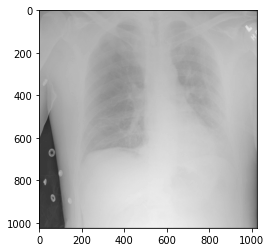

In [12]:
# plotting image
import pydicom as dicom
import matplotlib.pylab as plt

image_path = 'stage_2_train_images/' + min_filename
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array, cmap='gray')

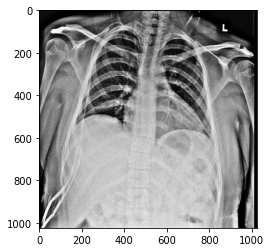

In [13]:
# plotting another image
image_path = 'stage_2_train_images/' + max_filename
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array, cmap='gray')

In [14]:
# finding minimum and maximum image size for training images
min_size = os.path.getsize('stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')
max_size = os.path.getsize('stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')
d = "stage_2_test_images"
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        size = os.path.getsize(d + "/" + path)
        if size < min_size:
            min_size = size
            min_filename = path
        if size > max_size:
            max_size = size
            max_filename = path
            
print(min_size)
print(max_size)

46242
189830


In [15]:
# plotting dcm metadata details for one image
image_path = 'stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'
ds = dicom.dcmread(image_path, force = True)

ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [1]:
# importing metadata details for testing imaages to an excel file
import pickle

d = "stage_2_train_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        dat1 = ds[16,32].value
        dat2 = ds[16,64].value
        dat3 = ds[16,4112].value
        dat4 = ds[24,21].value
        data = data + dat1 + ',' + dat2 + ',' + dat3 + ',' + dat4 + ',' + '\n'
        with open('images_more_data_training.csv', 'wb') as fp:
            pickle.dump(data, fp)

NameError: ignored

In [ ]:
# importing metadata details for training images to an excel file
 = "stage_2_test_images"
data = ""
for path in os.listdir(d):
    if os.path.isfile(os.path.join(d, path)):
        ds = dicom.dcmread(d + "/" + path)
        dat1 = ds[16,32].value
        dat2 = ds[16,64].value
        dat3 = ds[16,4112].value
        dat4 = ds[24,21].value
        data = data + dat1 + ',' + dat2 + ',' + dat3 + ',' + dat4 + ',' + '\n'
        with open('images_more_data_test.csv', 'wb') as fp:
            pickle.dump(data, fp)

In [ ]:
import pandas as pd

class_info = pd.read_csv("stage_2_detailed_class_info.csv")

class_info.shape

class_info.head(10)

class_info.describe()

class_info['class'].unique()

import seaborn as sb

sb.countplot(x='class',data=class_info)

class_info.isnull().sum()

# same for train_labels csv